## Import libraries

In [1]:
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from matplotlib import pyplot
import pingouin as pg

## Define functions to import and analyze CNV data

In [2]:
# Import the list of genes used in Caris' panel
def caris_Gene_Panel():
    gene_panel = pd.read_csv("~/gene_panel.txt", delimiter='\t', header= None)
    gene_panel = gene_panel[0].tolist()
    return gene_panel

# Imports copy number data as is from cbioportal
# Each row is a gene CNV and each column is a sample
def TCGA_cnv_data():
    data_cna = pd.read_csv("~/data_cna.txt", delimiter='\t')
    data_cna = data_cna.set_index("Hugo_Symbol")

    return data_cna

# Fetch the length of each genes from a pre-computed lookup table
# The input is a list of Hugo Gene IDs
def find_gene_lengths(genes):
    #genes = ["TP53", "APC"]
    lenGenes_lookup_table = pd.read_csv("~/Gene_lengths_table", delimiter='\t', index_col=0)
    genes = lenGenes_lookup_table.index.intersection(genes)
    lenGenes = lenGenes_lookup_table.loc[genes]
    return lenGenes

# Estimates the fraction of genome altered
# Takes as input (i) 'gene_panel' which is a list of Hugo Symbol IDs and 
# (ii) 'cnv data', a data frame where each row is a gene CNV and a sample
def estimate_FGA(gene_panel, 
                 cnv_data):
    gene_panel_lengths = find_gene_lengths(gene_panel)
    total_effective_genome = sum(gene_panel_lengths["Length"])
    fga_panel = {}
    for sample in cnv_data.columns:
        sample_gene_cnv = cnv_data[sample]
        altered_genes = sample_gene_cnv[sample_gene_cnv != 0].index
        altered_genes = altered_genes.intersection(gene_panel_lengths.index.to_list())
        altered_genome = sum(gene_panel_lengths.loc[altered_genes.to_list()]["Length"])
        fga_panel[sample] = altered_genome/total_effective_genome

    fga_panel =  pd.DataFrame(data=fga_panel, index=[0])
    return fga_panel

## Analysis

#### Import Caris' list of genes

In [3]:
caris_gene_panel = caris_Gene_Panel()

#### Import CNV data
CNV data should be a dataframe where each row is a gene CNV and each column is a sample.
Here, we take as example TCGA data downloaded from cbioportal.

In [4]:
cnv_data = TCGA_cnv_data()

#### Compute FGA based on WES (leverages all genes) and Caris gene panel (731 genes)


In [5]:
wes_fga = estimate_FGA(list(cnv_data.index[1:]), cnv_data)
panel_fga = estimate_FGA(caris_gene_panel, cnv_data)

#### Add the estimated FGAs to the CNV tables

In [6]:
cnv_data.loc["Fraction Genome Altered"] = None
cnv_data.loc["Estimated Fraction Genome Altered"] = None
cnv_data.loc["Fraction Genome Altered"][1:511] = wes_fga[list(cnv_data.columns[:-2])].iloc[0].tolist()
cnv_data.loc["Estimated Fraction Genome Altered"][1:511] = panel_fga[list(cnv_data.columns[:-2])].iloc[0].tolist()
cnv_data = cnv_data.transpose()

/var/folders/q4/jx094y8j56zbbcwc8gd6ft4rwk7m14/T/ipykernel_28217/4257222431.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cnv_data.loc["Fraction Genome Altered"] = None
/var/folders/q4/jx094y8j56zbbcwc8gd6ft4rwk7m14/T/ipykernel_28217/4257222431.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cnv_data.loc["Estimated Fraction Genome Altered"] = None


## Compute correlation 

In [7]:
pg.corr(x=cnv_data['Fraction Genome Altered'], y=cnv_data['Estimated Fraction Genome Altered'])

,n,r,CI95%,p-val,BF10,power
pearson,510,0.992192,"[0.99, 0.99]",0.0,nan,1.0


## Plot correlation 

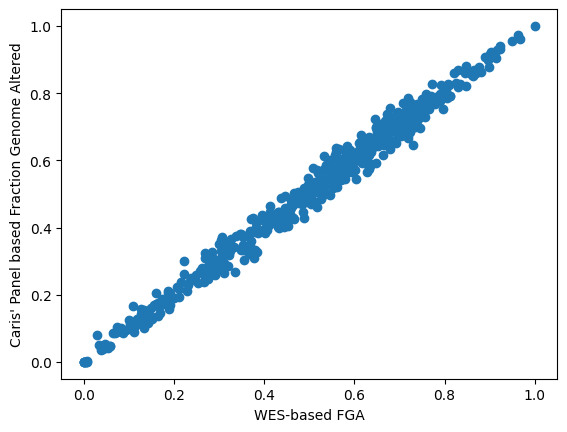

In [8]:
pyplot.scatter(cnv_data['Fraction Genome Altered'], cnv_data['Estimated Fraction Genome Altered'])
pyplot.xlabel("WES-based FGA")
pyplot.ylabel("Caris' Panel based Fraction Genome Altered")
pyplot.show()